# Coding Challenge: Gene Knockout Analysis with Embeddings - Task 1: Design an In-Silico Perturbation Workflow

The goal of this task is to develop a workflow to simulate knock-up and knock-down experiments for specified genes. The workflow should provide flexibility for scaling to multiple genes.

Here we use the `helical` package set up the workflow.  

In [1]:
%load_ext autoreload
%autoreload 2

## Load packages

In [ ]:
import logging
import warnings

import os

import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from itertools import combinations
from collections import defaultdict

import scanpy as sc

from helical.models.geneformer import Geneformer, GeneformerConfig
import torch

import matplotlib.pyplot as plt


In [3]:
sc.logging.print_versions()

Package,Version
numpy,1.26.4
pandas,2.2.2
scikit-learn,1.7.2
anndata,0.12.4
scanpy,1.11.5
umap-learn,0.5.9.post2
helical,1.4.6
torch,2.6.0
seaborn,0.13.2
matplotlib,3.10.7


Import custom code for perturbation and perturbation analysis.

In [15]:
from anndata_perturbation import AnnDataPerturbationModel
from perturbation_analysis import PerturbationAnalyzer

## Set paths and load data

In [ ]:
project_path = './'
data_dir = os.path.join(project_path, "data")
table_dir = os.path.join(project_path, "tables")
figure_dir = os.path.join(project_path, "figures")
# set scanpy figure path in addition
sc.settings.figdir = os.path.join(project_path, "figures")
# load data in anndata format
adata = sc.read(os.path.join(project_path, data_dir, "counts_combined_filtered_BA4_sALS_PN.h5ad"))

## Inspection of the data object

In [5]:
adata

AnnData object with n_obs × n_vars = 112014 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL2', 'Cellstates_LVL3', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'split'
    var: 'Biotype', 'Chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ENSID', 'mt', 'n_cells', 'biotype'

Let us check if there is a `.raw` anndata object.

In [6]:
adata.raw

Let us inspect the `.X` object for its data distribution.

In [10]:
print(f"Data type of data matrix .X is: {adata.X.dtype}")
print(f"Minimum value in .X: {adata.X.min()}")
print(f"Maximum value in .X: {adata.X.max()}")

Data type of data matrix .X is: int32
Minimum value in .X: 0
Maximum value in .X: 4141


We suspect that the data matrix is a count matrix, which is not normalized, yet.

Let us check the distribution of total counts per cell.

In [8]:
total_count = adata.X.sum(axis=1)

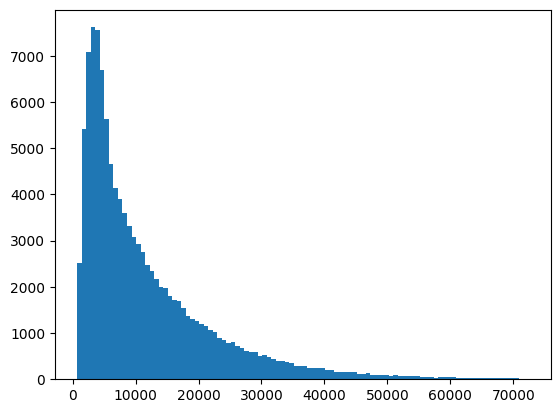

In [9]:
counts_bins = plt.hist(total_count, bins=100)
plt.show()

In [10]:
np.percentile(total_count.A1, q=[0, 25, 50, 75, 100])

array([  757.,  4126.,  8072., 15943., 72386.])

Let us get an overview on the cell specific metadata and characteristic (`.obs` object).

In [11]:
adata.obs.describe()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes
count,112014.000000,112014.000000,112014.000000,112014.000000,112014.000000,112014.000000,112014.000000,112014.000000
mean,3867.078160,8.111811,12324.497750,9.041968,218.171148,3.922555,1.316946,3867.078160
std,2035.549452,0.563934,11271.812071,0.889115,492.460399,1.814722,1.896419,2035.549452
min,651.000000,6.480045,790.000000,6.673298,0.000000,0.000000,0.000000,651.000000
25%,2165.000000,7.680637,4306.000000,8.367997,12.000000,2.564949,0.206444,2165.000000
50%,3455.000000,8.147867,8449.000000,9.041922,46.000000,3.850148,0.620465,3455.000000
75%,5324.000000,8.580168,16705.000000,9.723523,203.000000,5.318120,1.639515,5324.000000
max,11084.000000,9.313348,74977.000000,11.224950,11362.000000,9.338118,19.908878,11084.000000


Note, the percentile values of `total_counts` and the percentiles of `total_counts` in the `adata.obs` metadata table are relatively close, but not identical. That is potentially due to differences in pre-processing and cell filtering steps. 

We conclude that the data matrix is a count matrix without further normalization.

In [12]:
adata.obs.describe(include='category')

,Sample_ID,Donor,Region,Sex,Condition,Group,C9_pos,CellClass,CellType,SubType,full_label,DGE_Group,Bakken_M1,data_merge_id,data_sample_id,Cellstates_LVL1,Cellstates_LVL2,Cellstates_LVL3,split
count,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014,112014
unique,33,33,1,2,2,2,1,4,19,40,43,33,121,1,33,4,19,43,2
top,191112_ALS_117_snRNA-C3,117,BA4,F,ALS,SALS,0.0,Glia,Oligo,nan,Glia.Oligo,Glia.Oligo,Oligo.L2_6.OPALIN_FTH1P3,Pineda_etal,6,Glia,Oligo,Glia.Oligo,train
freq,7383,7383,112014,60826,66960,66960,112014,46402,19043,33401,19043,19043,18309,112014,7383,46402,19043,19043,73865


The columns `Region` and `C9_pos` contain only a single entry. 

Let us further inspect the annotated groups and conditions to get an overview of the available metadata.

In [14]:
mut_info_dict = {}
col_categorical = adata.obs.describe(include='category').columns
col_combo = combinations(col_categorical, 2)

mut_info_dict = defaultdict(dict)
for x_col, y_col in col_combo:
   
   mut_info_dict[x_col][y_col] = normalized_mutual_info_score(adata.obs[x_col], adata.obs[y_col]) 


Here we use the normalized mutual information to identify identical metadata columns.

In [15]:
pd.DataFrame.from_dict(mut_info_dict).style.background_gradient(axis=None, vmin=0, vmax=1, cmap='YlGnBu').format(precision=2)

,Sample_ID,Donor,Region,Sex,Condition,Group,C9_pos,CellClass,CellType,SubType,full_label,DGE_Group,Bakken_M1,data_merge_id,data_sample_id,Cellstates_LVL1,Cellstates_LVL2,Cellstates_LVL3
Donor,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Region,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Sex,0.34,0.34,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Condition,0.33,0.33,0.00,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Group,0.33,0.33,0.00,0.01,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C9_pos,0.00,0.00,1.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CellClass,0.02,0.02,0.00,0.00,0.01,0.01,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CellType,0.05,0.05,0.00,0.00,0.01,0.01,0.00,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SubType,0.04,0.04,0.00,0.00,0.01,0.01,0.00,0.57,0.87,nan,nan,nan,nan,nan,nan,nan,nan,nan
full_label,0.05,0.05,0.00,0.00,0.01,0.01,0.00,0.54,0.93,0.95,nan,nan,nan,nan,nan,nan,nan,nan


The columns `Condition` and `Group` share the same information. Double check with `crosstab`.

We also note that `SampleID` and `Donor`, as well as `Cellstates_LVL1` and `CellClass`, `Cellstates_LVL2` and `CellType`, and `Cellstate_LVL3` and `full_label` share the same information.

In [16]:
pd.crosstab(adata.obs['Condition'], adata.obs['Group'])

Group,PN,SALS
Condition,,
ALS,0,66960
PN,45054,0


In [17]:
pd.crosstab(adata.obs['Condition'], adata.obs['Sex'])

Sex,F,M
Condition,,
ALS,33628,33332
PN,27198,17856


In [18]:
pd.crosstab(adata.obs['Condition'], [adata.obs['Sex'], adata.obs['Donor']]).T

Condition   ALS    PN
Sex Donor            
F   101    4708     0
    102     195     0
    103    3663     0
    104    3495     0
    106    3545     0
    108    4248     0
    110    6181     0
    111    4890     0
    112    2703     0
    301       0  3902
    302       0  3589
    303       0  3825
    304       0  3116
    306       0  1882
    307       0  3646
    309       0  4958
    311       0  2280
M   116    4556     0
    117    7383     0
    118    5395     0
    120    5215     0
    122    1759     0
    124    3225     0
    126    2147     0
    127    3652     0
    317       0  2833
    318       0   673
    319       0   807
    322       0  1887
    323       0  1217
    324       0  3371
    325       0  3198
    328       0  3870

Donor and Sex distribution vs Disease group are balanced in this dataset. 

Let us inspect the gene specific characteristics and metadata (`.var` object).

In [19]:
adata.var.describe()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
count,22832.000000,22832.000000,22832.000000,22832.000000,2.283200e+04,22832.000000,22832.000000
mean,105590.250131,0.576942,0.274209,83.131820,3.611503e+05,10.246359,105590.250131
std,130201.565185,3.173421,0.442411,20.799869,1.986476e+06,3.026428,130201.565185
min,3.000000,0.000005,0.000005,0.000000,3.000000e+00,1.386294,3.000000
25%,3773.000000,0.006543,0.006522,72.812845,4.096000e+03,8.318010,3773.000000
50%,47662.000000,0.093811,0.089668,92.385934,5.872300e+04,10.980604,47662.000000
75%,170184.250000,0.430436,0.357979,99.397258,2.694415e+05,12.504110,170184.250000
max,625973.000000,341.972542,5.837650,99.999521,2.140656e+08,19.181793,625973.000000


In [20]:
adata.var.describe(include='category')

,Biotype,Chromosome,biotype
count,22832,22832,22832
unique,4,26,2
top,protein_coding,1,protein_coding
freq,18493,2349,18491


Check `var_names` to ensure that the dataset originates from human.

In [21]:
adata.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'LINC01622', 'SMIM40', 'MICB-DT', 'H3C3', 'LINCADL', 'THCAT155',
       'RENO1', 'PTCSC1', 'FAM242B', 'FAM106C'],
      dtype='object', name='Gene', length=22832)

## Load model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Set model configuration. 

In [8]:
model_config = GeneformerConfig(model_name="gf-12L-95M-i4096", batch_size=10, device=device)
geneformer_v2 = Geneformer(model_config)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cpu' with embedding mode 'cell'.


## Process data and generate embeddings.

We noted in the data inspection section, that the `anndata` object does not encompass any data processing except for initial cell and gene filtering, or low-dimensional embeddings. 

Here we use the `helical` wrapper function for the `geneformer` Transcriptome Tokenizer to process the data. 

**Comment:** To keep the compute time on my MacBook in a reasonable time frame (i.e. less than 70 h to compute an embedding on the full dataset), I subset the data to 1,000 observations.

In [17]:
adata_1k = sc.pp.sample(adata, n=1000, copy = True)

In [18]:
# Initialize (tokenizes and embeds original data once)
perturb_model = AnnDataPerturbationModel(
    foundation_model=geneformer_v2,
    adata=adata_1k,
    normalize_embeddings=True
)

INFO:helical.models.geneformer.model:Processing data for Geneformer.


Tokenizing original data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 1000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing original embeddings...


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


Original embeddings shape: (1000, 512)


Save model to file.

In [103]:
import pickle

In [104]:
with open(os.path.join(data_dir, 'perturbmodel_1k_01.pkl'), 'wb') as handle:
    pickle.dump(perturb_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Simulate a knockdown and a knockup

Here we set up a simulation for gene knockdown (i.e. reduction of expression level by a fixed factor) and overexpression (i.e. increase of expression level by a fixed factor). The perturbation model uses all genes of the input list for the perturbation. 

We use use two genes to perturb to exemplify the workflow. 

In [26]:
genes_to_perturb = ['ANXA11','SOD1']

For simplicity, we subset to the `Oligo` cell type in the `PN` condition.

In [23]:
celltype_mask = (adata_1k.obs['CellType'] == 'Oligo') & (adata_1k.obs['Condition'] == 'PN') 
celltype_indices = np.where(celltype_mask)[0]

In [24]:
len(celltype_indices)

75

In [39]:
# Gene overexpression
result_oe = perturb_model.overexpression(
    genes=genes_to_perturb,
    cell_indices=celltype_indices,
    fold_change=2.0
)

# Gene knockdown
result_kd = perturb_model.knockdown(
    genes=genes_to_perturb,
    cell_indices=celltype_indices,
    reduction_factor=0.5
)

INFO:helical.models.geneformer.model:Processing data for Geneformer.


Creating perturbed AnnData (overexpression: ANXA11, SOD1, FC=2.0)...
AnnData object with n_obs × n_vars = 1000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL2', 'Cellstates_LVL3', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'split'
    var: 'Biotype', 'Chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ENSID', 'mt', 'n_cells', 'biotype', 'index', 'ensembl_id', 'ensembl_id_collapsed'
Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 1000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Processing data for Geneformer.


Creating perturbed AnnData (knockdown: ANXA11, SOD1, factor=0.5)...
AnnData object with n_obs × n_vars = 1000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL2', 'Cellstates_LVL3', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'split'
    var: 'Biotype', 'Chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ENSID', 'mt', 'n_cells', 'biotype', 'index', 'ensembl_id', 'ensembl_id_collapsed'
Tokenizing perturbed data...


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/marenbuettner/Library/Caches/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 1000 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LVL1', 'Cellstates_LVL

Computing perturbed embeddings...


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


Save perturbed embeddings to file.

In [105]:
with open(os.path.join(data_dir, 'perturbmodel_1k_oligo_knockup.pkl'), 'wb') as handle:
    pickle.dump(result_oe, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(data_dir, 'perturbmodel_1k_oligo_knockdown.pkl'), 'wb') as handle:
    pickle.dump(result_kd, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analyze perturbation results

Here we exemplify the analysis of the knockdown and knockup perturbation predictions.

### Knockdown

In [98]:
analyzer = PerturbationAnalyzer(result_kd)
rankings = analyzer.rank_by_effect_size(top_k=10, metric='cosine')


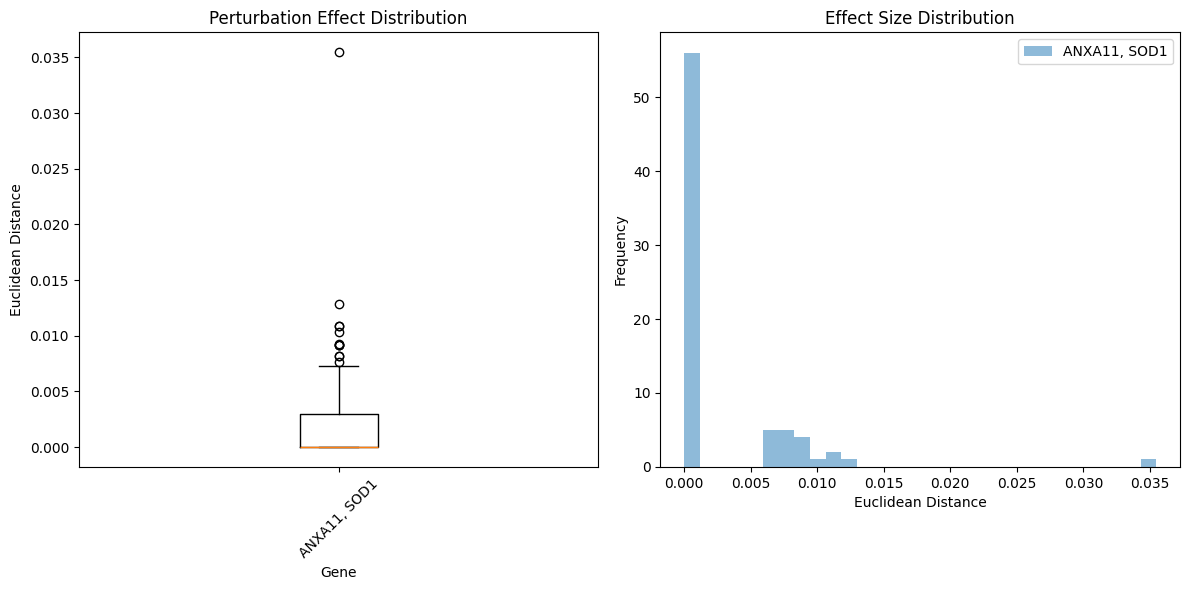

In [99]:
fig = analyzer.plot_effect_distribution()
plt.show()

  warn(



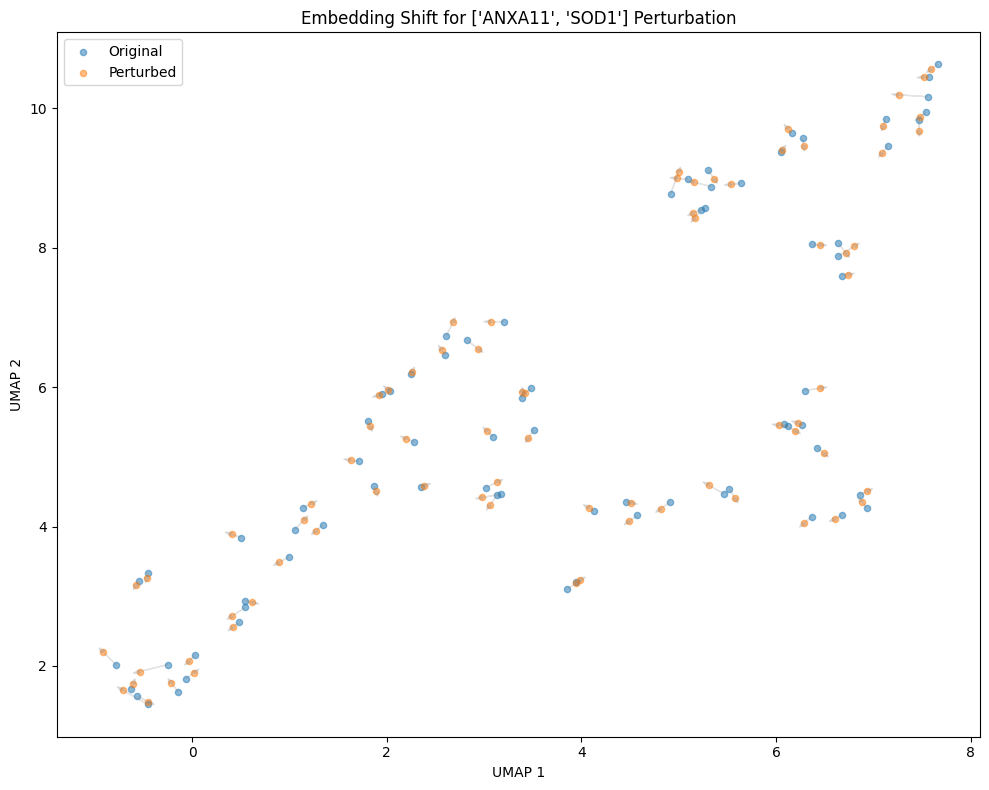

In [100]:
fig = analyzer.plot_embedding_shift(gene=result_kd.gene_names, method='umap', figsize=(10,8))
plt.show()

In [102]:
analyzer.export_results(output_path=os.path.join(table_dir, 'knockdown_perturbation.csv'))

Results exported to ./tables/knockdown_perturbation.csv


### Overexpression

In [80]:
analyzer = PerturbationAnalyzer(result_oe)
rankings = analyzer.rank_by_effect_size(top_k=10, metric='cosine')


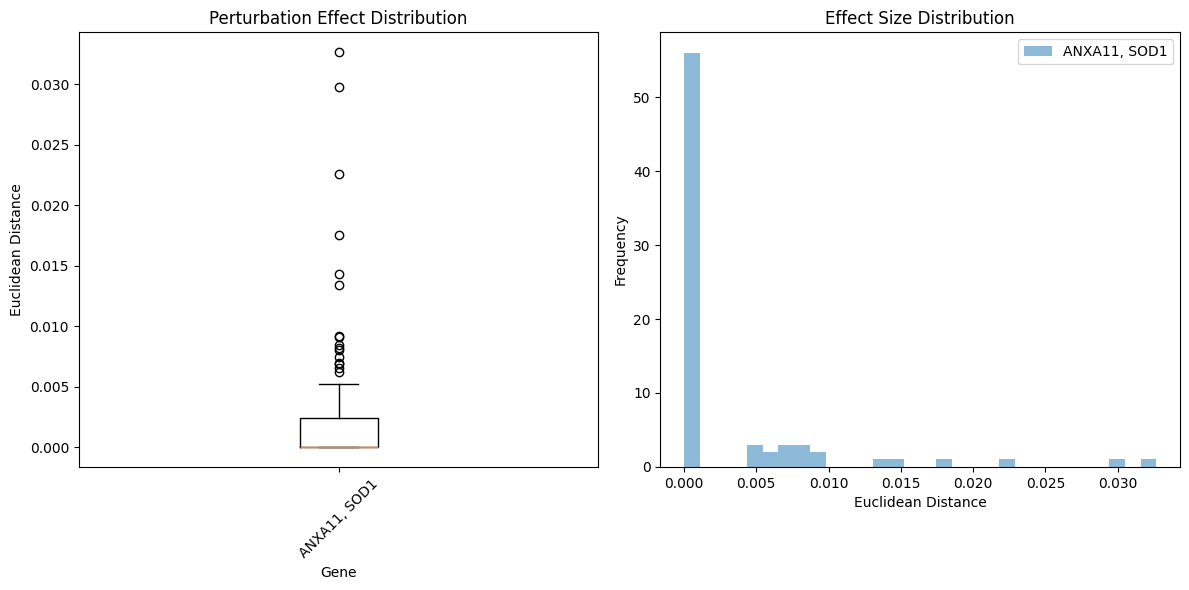

In [81]:
fig = analyzer.plot_effect_distribution()
plt.show()

  warn(



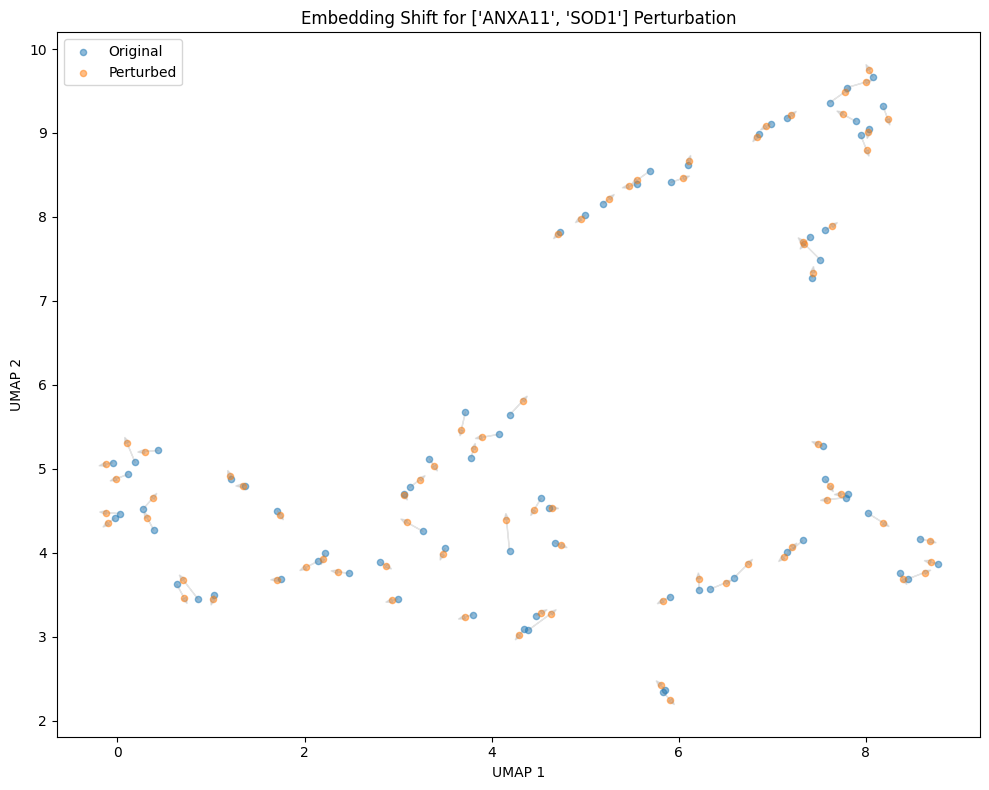

In [89]:
fig = analyzer.plot_embedding_shift(gene=result_oe.gene_names, method='umap', figsize=(10,8))
plt.show()

In [97]:
analyzer.export_results(output_path=os.path.join(table_dir, 'overexpression_perturbation.csv'))

Results exported to ./tables/overexpression_perturbation.csv


End of the workflow.